In [ ]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.special as scps
from statsmodels.graphics.gofplots import qqplot
from scipy.linalg import cholesky
from functools import partial
from scipy.optimize import minimize

from IPython.display import display
import sympy

sympy.init_printing()


def display_matrix(m):
    display(sympy.Matrix(m))

Here we are trying to compute the characteristic function of the Heston model.

u represents the complex argument of the characteristic function ;
t represents the time to maturity ;
v_0 represents the initial variance
mu represents the drift term of the underlying asset price.
kappa Speed of mean reversion of the variance.
theta represents the long-term mean of the variance.
sigma represents the volatility of the variance
rho represents the correlation between the underlying asset and its variance.

Here we go on to calculate the characteristic function of the Heston Model which essentially is the expectation value of exponential of i*t*x

In [ ]:
def cf_Heston(u, t, v0, mu, kappa, theta, sigma, rho):
    xi = kappa - sigma * rho * u * 1j
    d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j * u))
    g1 = (xi + d) / (xi - d)
    g2 = 1 / g1
    cf = np.exp(
        1j * u * mu * t
        + (kappa * theta) / (sigma**2) * ((xi - d) * t - 2 * np.log((1 - g2 * np.exp(-d * t)) / (1 - g2)))
        + (v0 / sigma**2) * (xi - d) * (1 - np.exp(-d * t)) / (1 - g2 * np.exp(-d * t))
    )
    return cf

In [ ]:
from scipy.integrate import quad
from functools import partial
import scipy.special as scps
from math import factorial

The stock market numeraire uses the stock price as the benchmark and evaluates probabilities accordingly ; this is useful for derivatives tied to the stock.

The money market numeraire uses a risk-free asset as the benchmark, ideal for discounting future cash flows.

The choice of numeraire impacts the valuation and interpretation of derivative prices.

In [ ]:
def Q1(k, cf, right_lim):

   # P(X<k) - Probability to be in the money under the stock numeraire.
   # right_lim: right limit of integration

    def integrand(u):
        return np.real((np.exp(-u * k * 1j) / (u * 1j)) * cf(u - 1j) / cf(-1.0000000000001j))

    return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit=2000)[0]


def Q2(k, cf, right_lim):
   # P(X<k) - Probability to be in the money under the money market numeraire
   # right_lim: right limit of integration

    def integrand(u):
        return np.real(np.exp(-u * k * 1j) / (u * 1j) * cf(u))

    return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit=2000)[0]




The  Gil Pelaez Inversion Theorem is a theorem which uses stuff from Fourier Transform to get the cumulative distribution function of a probability distribution from it's characteristic function

https://en.wikipedia.org/wiki/Characteristic_function_(probability_theory)

Go to this link, go to the Gil Pelaez theorem section ; I really do not know how the theorem works , I just used it here asking ChatGPT on how to implement it

In [ ]:
def Gil_Pelaez_pdf(x, cf, right_lim):
    def integrand(u):
        return np.real(np.exp(-u * x * 1j) * cf(u))

    return 1 / np.pi * quad(integrand, 1e-15, right_lim)[0]


def Heston_pdf(i, t, v0, mu, theta, sigma, kappa, rho):
    cf_H_b = partial(
        cf_Heston,
        t=t,
        v0=v0,
        mu=mu,
        theta=theta,
        sigma=sigma,
        kappa=kappa,
        rho=rho,
    )
    return Gil_Pelaez_pdf(i, cf_H_b, np.inf)




Now we seek to generate random values of stock price S and variance for some maturity T

In the Heston model, "paths" are simulated trajectories of a stock's price and its variance over time. Each path represents a possible future scenario influenced by random factors modeled as Brownian motions.

Stock price paths show potential price changes, while variance paths depict changes in volatility.


The `heston_paths_log` function is to ensure numerical stability and positive variance. Unlike direct simulation,this prevents issues like negative variances and overflow/underflow. We discard paths with extreme values or NaNs

In [ ]:
def heston_paths(N, paths, T, S0, v0, mu, rho, kappa, theta, sigma):
    dt = T / (N - 1)
    dt_sq = np.sqrt(dt)

    assert 2 * kappa * theta > sigma**2


    v_T = np.zeros(paths)
    S_T = np.zeros(paths)
    v = np.zeros(N)
    S = np.zeros(N)

    for path in range(paths):
        # Generate random Brownian Motions
        W_S = np.random.normal(loc=0, scale=1, size=N-1)
        W_v = rho * W_S + np.sqrt(1 - rho**2) * np.random.normal(loc=0, scale=1, size=N-1)

        S[0] = S0  # stock at 0
        v[0] = v0  # variance at 0
        print(f"Beginning New Path Now : {path}")

        for t in range(N - 1):
            print(f"Beginning number {t}")
            v[t + 1] = np.abs(v[t] + kappa * (theta - v[t]) * dt + sigma * np.sqrt(v[t]) * dt_sq * W_v[t])
            S[t + 1] = S[t] * np.exp((mu - 0.5 * v[t]) * dt + np.sqrt(v[t]) * dt_sq * W_S[t])

        S_T[path] = S[N - 1]
        v_T[path] = v[N - 1]

    return np.asarray(S_T), np.asarray(v_T)


def heston_paths_log(N, paths, T, S0, v0, mu, rho, kappa, theta, sigma):
    dt = T / (N - 1)
    dt_sq = np.sqrt(dt)

    X0 = np.log(S0)  # log price
    Y0 = np.log(v0)  # log-variance

    assert 2 * kappa * theta > sigma**2  # Feller condition
    std_asy = np.sqrt(theta * sigma**2 / (2 * kappa))

    # Initialize
    Y_T = np.zeros(paths)
    X_T = np.zeros(paths)
    Y = np.zeros(N)
    X = np.zeros(N)

    up_bound = np.log(theta + 10 * std_asy)  # mean + 10 standard deviations
    warning = 0
    counter = 0

    # Generate paths
    for path in range(paths):
        # Generate random Brownian Motions
        W_S = np.random.normal(loc=0, scale=1, size=N - 1)
        W_v = rho * W_S + np.sqrt(1 - rho**2) * np.random.normal(loc=0, scale=1, size=N - 1)

        X[0] = X0  # log-stock
        Y[0] = Y0  # log-variance

        for t in range(N - 1):
            v = np.exp(Y[t])  # variance
            v_sq = np.sqrt(v)  # square root of variance

            Y[t + 1] = Y[t] + (1 / v) * (kappa * (theta - v) - 0.5 * sigma**2) * dt + sigma * (1 / v_sq) * dt_sq * W_v[t]
            X[t + 1] = X[t] + (mu - 0.5 * v) * dt + v_sq * dt_sq * W_S[t]

        if Y[-1] > up_bound or np.isnan(Y[-1]):
            warning = 1
            counter += 1
            X_T[path] = 10000
            Y_T[path] = 10000
            continue

        X_T[path] = X[-1]
        Y_T[path] = Y[-1]

    if warning == 1:
        print("WARNING: ", counter, " paths have been removed because of the overflow.")
        print("SOLUTION: Use a bigger value N.")

    Y_arr = np.asarray(Y_T)
    Y_good = Y_arr[Y_arr < up_bound]
    X_good = np.asarray(X_T)[Y_arr < up_bound]

    return np.exp(X_good), np.exp(Y_good)


Now we generate 1,000,000 samples from a bivariate normal distribution with mean vector [0, 0] and covariance matrix [[1, 0.6], [0.6, 1]].

We then seek the correlation matrix from the generated samples

In [ ]:
SIZE = 1000000
rho = 0.6

MU = np.array([0, 0])
COV = np.array([[1, rho], [rho, 1]])
print("COV: ")
display_matrix(COV)

Y = ss.multivariate_normal.rvs(mean=MU, cov=COV, size=SIZE)

print("correlation matrix: ")
display_matrix(np.corrcoef(Y.T).round(2))

COV: 


⎡1.0  0.6⎤
⎢        ⎥
⎣0.6  1.0⎦

correlation matrix: 


⎡1.0  0.6⎤
⎢        ⎥
⎣0.6  1.0⎦

In [ ]:
Y_1 = np.random.normal(loc=0, scale=1, size=SIZE)
Y_2 = rho * Y_1 + np.sqrt(1 - rho**2) * np.random.normal(loc=0, scale=1, size=SIZE)
print("correlation matrix: ")
display_matrix(np.corrcoef(Y_1, Y_2).round(2))

correlation matrix: 


⎡1.0  0.6⎤
⎢        ⎥
⎣0.6  1.0⎦

In [ ]:
print("Cholesky: ")
display_matrix(cholesky(COV))
print("Correlation matrix: ")
display_matrix(cholesky(COV, lower=True) @ cholesky(COV))

Cholesky: 


⎡1.0  0.6⎤
⎢        ⎥
⎣ 0   0.8⎦

Correlation matrix: 


⎡1.0  0.6⎤
⎢        ⎥
⎣0.6  1.0⎦

Now we simulate paths for the Heston model:  we initialize parameters including time steps N = 1,000,000,  paths = 3, and model characteristics like drift, correlation, mean reversion , and variance of volatility

We generates correlated Brownian motion and updates paths for log-transformed stock prices and variances over the defined time horizon T  

We ensure stability by the Feller condition

In Heston Model we generally use the CIR model to understand variance dynamics ; do not really know why

In [ ]:
%%time
np.random.seed(seed=42)

N = 1000000
paths = 3
T = 1
T_vec, dt = np.linspace(0, T, N, retstep=True)
dt_sq = np.sqrt(dt)

S0 = 100  # spot price
X0 = np.log(S0)  # log price
v0 = 0.04  # spot variance
Y0 = np.log(v0)  # log-variance

mu = 0.1
rho = -0.2
kappa = 2
theta = 0.04
sigma = 0.3
std_asy = np.sqrt(theta * sigma**2 / (2 * kappa))  # for the Cox Ingoll Russell Process
assert 2 * kappa * theta > sigma**2  # Feller condition

MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = ss.multivariate_normal.rvs(mean=MU, cov=COV, size=(N - 1, paths))
W_S = W[:, :, 0]  # Stock Brownian motion:     W_1
W_v = W[:, :, 1]  # Variance Brownian motion:  W_2

Y = np.zeros((N, paths))
Y[0, :] = Y0
X = np.zeros((N, paths))
X[0, :] = X0
v = np.zeros(N)

# Generate paths
for t in range(0, N - 1):
    v = np.exp(Y[t, :])  # variance
    v_sq = np.sqrt(v)  # standard deviation

    Y[t + 1, :] = (
        Y[t, :] + (1 / v) * (kappa * (theta - v) - 0.5 * sigma**2) * dt + sigma * (1 / v_sq) * dt_sq * W_v[t, :]
    )
    X[t + 1, :] = X[t, :] + (mu - 0.5 * v) * dt + v_sq * dt_sq * W_S[t, :]

CPU times: user 1min 5s, sys: 4.82 s, total: 1min 10s
Wall time: 1min 6s


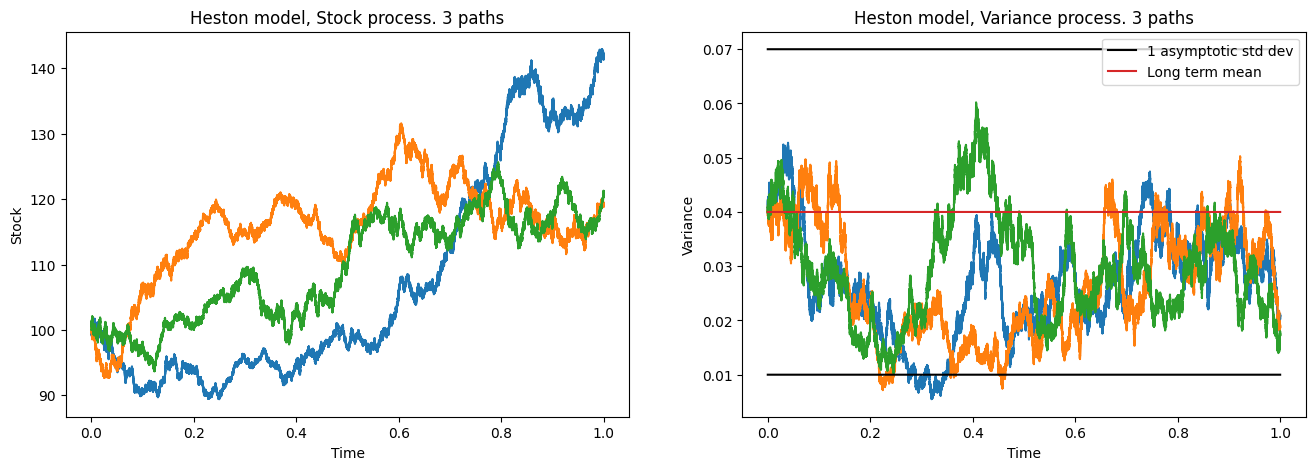

In [ ]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(T_vec, np.exp(X))
ax1.set_title("Heston model, Stock process. 3 paths")
ax1.set_xlabel("Time")
ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y))
ax2.set_title("Heston model, Variance process. 3 paths")
ax2.set_xlabel("Time")
ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy) * np.ones_like(T_vec), label="1 asymptotic std dev", color="black")
ax2.plot(T_vec, (theta - std_asy) * np.ones_like(T_vec), color="black")
ax2.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean")
ax2.legend(loc="upper right")
plt.show()

In [ ]:
mu = 0.1  # drift
rho = -0.9  # correlation coefficient
kappa = 2  # mean reversion coefficient
theta = 0.04  # long-term mean of the variance
sigma = 0.3  # (Vol of Vol) - Volatility of instantaneous variance
T = 1  # Time to maturity
v0 = 0.04  # spot variance
S0 = 100  # spot stock price

c = 2 * kappa / ((1 - np.exp(-kappa * T)) * sigma**2)
df = 4 * kappa * theta / sigma**2  # degrees of freedom
nc = 2 * c * v0 * np.exp(-kappa * T)  # non-centrality parameter

In [ ]:
_, _ = heston_paths_log(N=500, paths=20000, T=T, S0=S0, v0=v0, mu=mu, rho=rho, kappa=kappa, theta=theta, sigma=sigma)

SOLUTION: Use a bigger value N.


In [ ]:
%%time
S, V = heston_paths(N=2000, paths=2000, T=T, S0=S0, v0=v0, mu=mu, rho=rho, kappa=kappa, theta=theta, sigma=sigma)

Streaming output truncated to the last 5000 lines.
Beginning number 1001
Beginning number 1002
Beginning number 1003
Beginning number 1004
Beginning number 1005
Beginning number 1006
Beginning number 1007
Beginning number 1008
Beginning number 1009
Beginning number 1010
Beginning number 1011
Beginning number 1012
Beginning number 1013
Beginning number 1014
Beginning number 1015
Beginning number 1016
Beginning number 1017
Beginning number 1018
Beginning number 1019
Beginning number 1020
Beginning number 1021
Beginning number 1022
Beginning number 1023
Beginning number 1024
Beginning number 1025
Beginning number 1026
Beginning number 1027
Beginning number 1028
Beginning number 1029
Beginning number 1030
Beginning number 1031
Beginning number 1032
Beginning number 1033
Beginning number 1034
Beginning number 1035
Beginning number 1036
Beginning number 1037
Beginning number 1038
Beginning number 1039
Beginning number 1040
Beginning number 1041
Beginning number 1042
Beginning number 1043
Beg

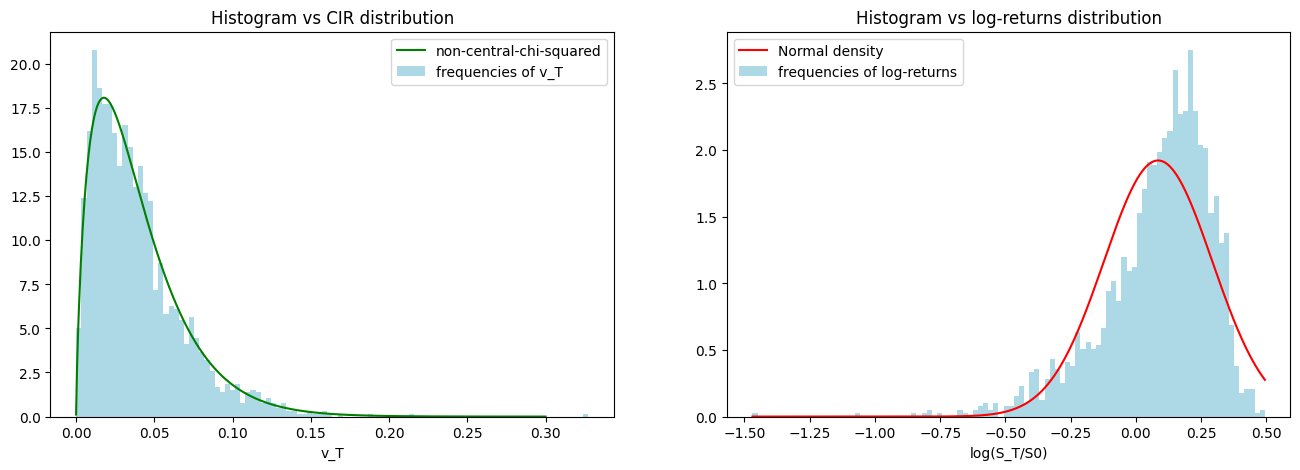

In [ ]:
log_R = np.log(S / S0)
x = np.linspace(log_R.min(), log_R.max(), 500)
y = np.linspace(0.00001, 0.3, 500)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(y, ss.ncx2.pdf(y, df, nc, scale=1 / (2 * c)), color="green", label="non-central-chi-squared")
ax1.hist(V, density=True, bins=100, facecolor="LightBlue", label="frequencies of v_T")
ax1.legend()
ax1.set_title("Histogram vs CIR distribution")
ax1.set_xlabel("v_T")

ax2.plot(x, ss.norm.pdf(x, log_R.mean(), log_R.std(ddof=0)), color="r", label="Normal density")
ax2.hist(log_R, density=True, bins=100, facecolor="LightBlue", label="frequencies of log-returns")
ax2.legend()
ax2.set_title("Histogram vs log-returns distribution")
ax2.set_xlabel("log(S_T/S0)")
plt.show()

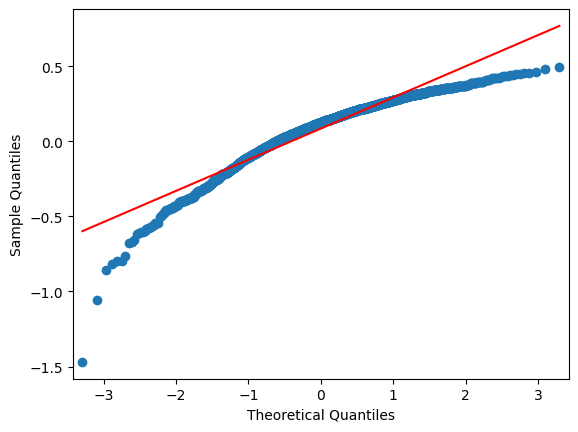

In [ ]:
qqplot(log_R, line="s")
plt.show()

In [ ]:
%%time
S2, _ = heston_paths(N=2000, paths=2000, T=T, S0=S0, v0=v0, mu=mu, rho=0.9, kappa=kappa, theta=theta, sigma=sigma)
log_R2 = np.log(S2 / S0)

Streaming output truncated to the last 5000 lines.
Beginning number 1683
Beginning number 1684
Beginning number 1685
Beginning number 1686
Beginning number 1687
Beginning number 1688
Beginning number 1689
Beginning number 1690
Beginning number 1691
Beginning number 1692
Beginning number 1693
Beginning number 1694
Beginning number 1695
Beginning number 1696
Beginning number 1697
Beginning number 1698
Beginning number 1699
Beginning number 1700
Beginning number 1701
Beginning number 1702
Beginning number 1703
Beginning number 1704
Beginning number 1705
Beginning number 1706
Beginning number 1707
Beginning number 1708
Beginning number 1709
Beginning number 1710
Beginning number 1711
Beginning number 1712
Beginning number 1713
Beginning number 1714
Beginning number 1715
Beginning number 1716
Beginning number 1717
Beginning number 1718
Beginning number 1719
Beginning number 1720
Beginning number 1721
Beginning number 1722
Beginning number 1723
Beginning number 1724
Beginning number 1725
Beg